In [1]:
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import re
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.util import ngrams
import time

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\avinash\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\avinash\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\avinash\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
def simple_sentence_splitter(text):
    sentences = re.split('[.!?]+', text)
    return [s.strip() for s in sentences if s.strip()]

In [3]:
df = pd.read_csv('promotional.csv')

In [4]:
print("Dataset Information:")
print(df.info())
print("\nSample of articles:")
print(df.head())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23837 entries, 0 to 23836
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    23837 non-null  object
 1   advert  23837 non-null  int64 
 2   coi     23837 non-null  int64 
 3   fanpov  23837 non-null  int64 
 4   pr      23837 non-null  int64 
 5   resume  23837 non-null  int64 
 6   url     23837 non-null  object
dtypes: int64(5), object(2)
memory usage: 1.3+ MB
None

Sample of articles:
                                                text  advert  coi  fanpov  pr  \
0  1 Litre no Namida 1, lit. 1 Litre of Tears als...       0    0       1   0   
1  1DayLater was free, web based software that wa...       1    1       0   0   
2  1E is a privately owned IT software and servic...       1    0       0   0   
3  1Malaysia pronounced One Malaysia in English a...       1    0       0   0   
4  The Jerusalem Biennale, as stated on the Bienn...       1    0 

In [5]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join(text.split())
    return text

In [6]:
df['cleaned_text'] = df['text'].apply(clean_text)

all_words = ' '.join(df['cleaned_text']).split()
word_freq = Counter(all_words)

In [7]:
sentences = df['cleaned_text'].str.split().tolist()
bigrams = [list(ngrams(sent, 2)) for sent in sentences]
trigrams = [list(ngrams(sent, 3)) for sent in sentences]

flat_bigrams = [item for sublist in bigrams for item in sublist]
flat_trigrams = [item for sublist in trigrams for item in sublist]

bigram_freq = Counter(flat_bigrams)
trigram_freq = Counter(flat_trigrams)

In [8]:
print("\nText Analysis Statistics:")
print(f"Total articles: {len(df)}")
print(f"Total words: {len(all_words)}")
print(f"Unique words: {len(word_freq)}")
print(f"Number of bigrams: {len(bigram_freq)}")
print(f"Number of trigrams: {len(trigram_freq)}")


Text Analysis Statistics:
Total articles: 23837
Total words: 17672550
Unique words: 291723
Number of bigrams: 4577280
Number of trigrams: 11384194


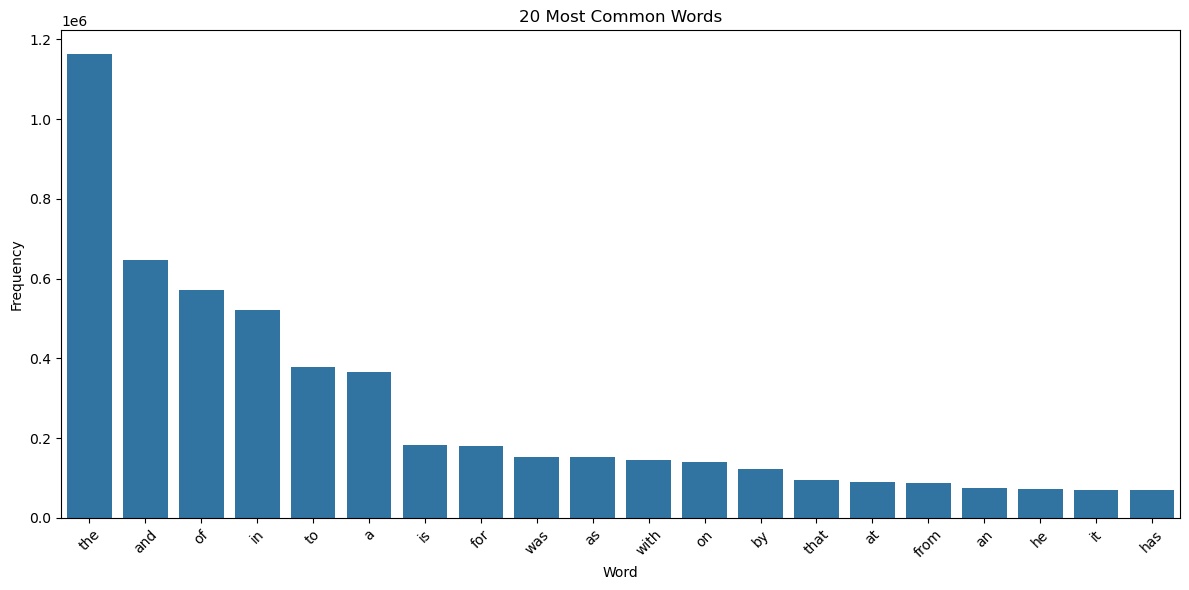

In [9]:
plt.figure(figsize=(12, 6))
most_common_df = pd.DataFrame(word_freq.most_common(20), columns=['Word', 'Frequency'])
sns.barplot(data=most_common_df, x='Word', y='Frequency')
plt.xticks(rotation=45)
plt.title('20 Most Common Words')
plt.tight_layout()
plt.show()

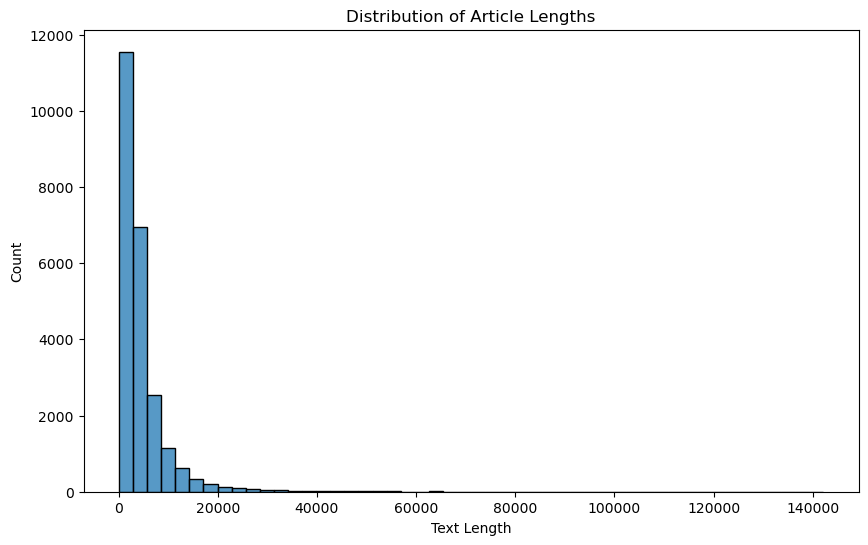

In [10]:
df['text_length'] = df['cleaned_text'].str.len()
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_length', bins=50)
plt.title('Distribution of Article Lengths')
plt.xlabel('Text Length')
plt.show()

In [11]:
df['sentences'] = df['text'].apply(simple_sentence_splitter)
df['sentence_count'] = df['sentences'].apply(len)

df['words_per_sentence'] = df['cleaned_text'].apply(lambda x: len(x.split())) / df['sentence_count']

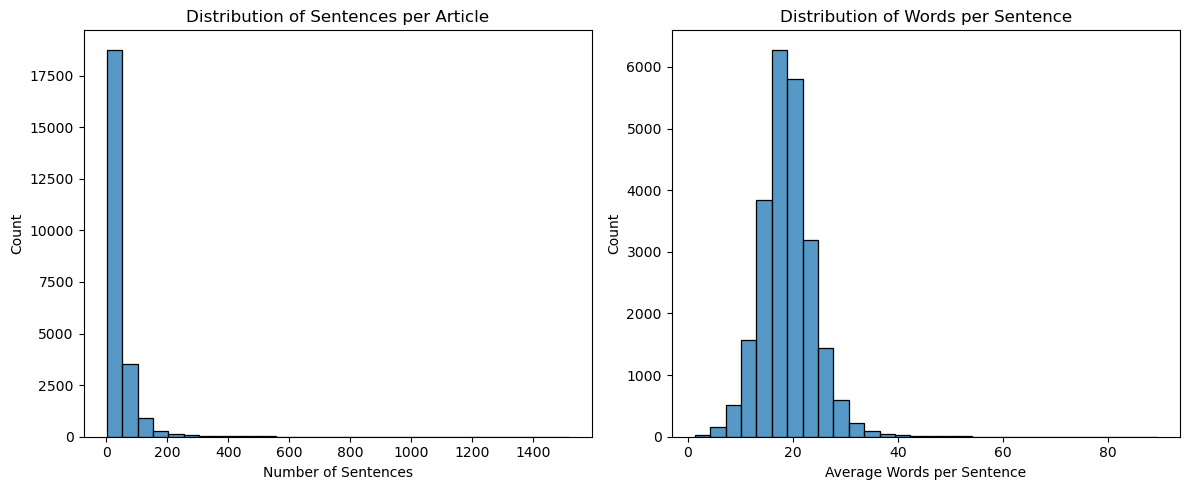

In [12]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='sentence_count', bins=30)
plt.title('Distribution of Sentences per Article')
plt.xlabel('Number of Sentences')

plt.subplot(1, 2, 2)
sns.histplot(data=df, x='words_per_sentence', bins=30)
plt.title('Distribution of Words per Sentence')
plt.xlabel('Average Words per Sentence')
plt.tight_layout()
plt.show()

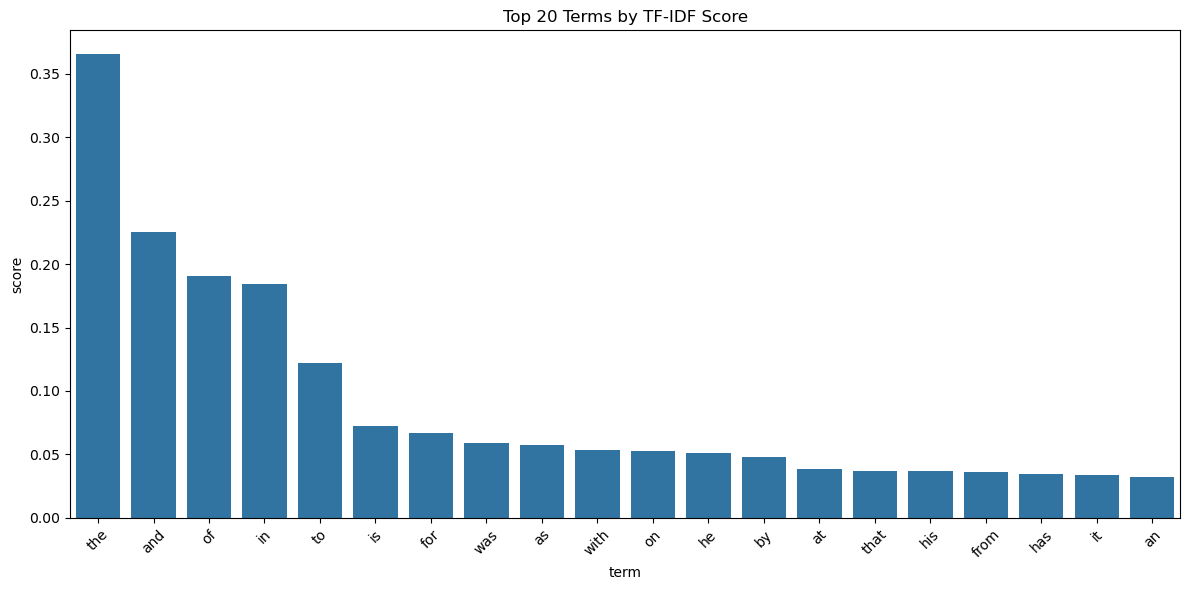

In [13]:
tfidf = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf.fit_transform(df['cleaned_text'])
feature_names = tfidf.get_feature_names_out()

avg_tfidf = np.array(tfidf_matrix.mean(axis=0)).flatten()
tfidf_scores = pd.DataFrame({'term': feature_names, 'score': avg_tfidf})
tfidf_scores = tfidf_scores.sort_values('score', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=tfidf_scores.head(20), x='term', y='score')
plt.xticks(rotation=45)
plt.title('Top 20 Terms by TF-IDF Score')
plt.tight_layout()
plt.show()

In [14]:
summary_stats = pd.DataFrame({
    'Metric': ['Total Articles','Total Words','Unique Words','Average Article Length','Average Sentence Count','Average Words per Sentence'],
    'Value': [len(df),len(all_words),len(word_freq),df['text_length'].mean(),df['sentence_count'].mean(),df['words_per_sentence'].mean()]})

print("\nSummary Statistics:")
print(summary_stats)

summary_stats.to_csv('text_analysis_summary.csv', index=False)


Summary Statistics:
                       Metric         Value
0              Total Articles  2.383700e+04
1                 Total Words  1.767255e+07
2                Unique Words  2.917230e+05
3      Average Article Length  4.566477e+03
4      Average Sentence Count  3.994999e+01
5  Average Words per Sentence  1.896821e+01


In [15]:
vocab_richness = len(word_freq) / len(all_words)
print(f"\nVocabulary Richness: {vocab_richness:.4f}")

word_stats = pd.DataFrame({'Word': list(word_freq.keys()),'Frequency': list(word_freq.values())})
word_stats['Frequency_Percentage'] = word_stats['Frequency'] / len(all_words) * 100
word_stats = word_stats.sort_values('Frequency', ascending=False)
word_stats.to_csv('word_statistics.csv', index=False)


Vocabulary Richness: 0.0165
